In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import glob

In [54]:
def get_stokes_i(fitsname):
    hdu = fits.open(fitsname)
    data = hdu[0].data
    #if len(data.shape) == 4:
    return data[0,0,:,:]
    #else:
        #print(data.shape)
        #return data

# plot a whole list of fits data files
# fits_names: if 2D list, makes plots along the second dimension, with corresponding
#             entries along the first dimension passed as a list to the combine function
def plot_all(fits_names, rows=1, combine=lambda d : d[0], lim=None, titles=None, 
             display_statistic=np.std):
    
    # turns fits_names into a 2D-list
    if not isinstance(fits_names, list):
        fits_names = [fits_names]
    if not isinstance(fits_names[0], list):
        fits_names = [fits_names]
    
    if lim == None or len(lim) < 2:
        lim = [None,None]
    
    if titles == None:
        titles = fits_names[0]
    
    cols = int(np.ceil(len(fits_names[0]) / rows))
    
    fig, axes = plt.subplots(figsize=(24,24),nrows=rows, ncols=cols, sharex=True,sharey=False)
    plt.rcParams.update({'font.size': 12})

    #make axes 2D
    if rows == 1:
        axes = [axes]
    if cols == 1:
        axes = [[x] for x in axes]

    for i in range(rows):
        for j in range(cols):  
            if cols * i + j >= len(fits_names[0]):
                break
            
            images = [get_stokes_i(fits_list[cols * i + j]) for fits_list in fits_names]
            data = combine(images)
            disp = round(display_statistic(data), 3)
                        
            im = axes[i][j].imshow(data,label=disp,vmin=lim[0],vmax=lim[1])
            axes[i][j].set_title('{}'.format(titles[cols * i + j]))
            #axes[i][j].set_xlabel('RA')
            #axes[i][j].set_ylabel('DEC')
            fig.colorbar(im,ax=axes[i][j],use_gridspec=True,fraction=0.046,pad=0.04)
            axes[i][j].text(400, 470, disp, bbox={'facecolor': 'white', 'pad': 10})
    
    return fig, axes

(<Figure size 1728x1728 with 4 Axes>,
 [array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f99f32a8910>,
        dtype=object)])

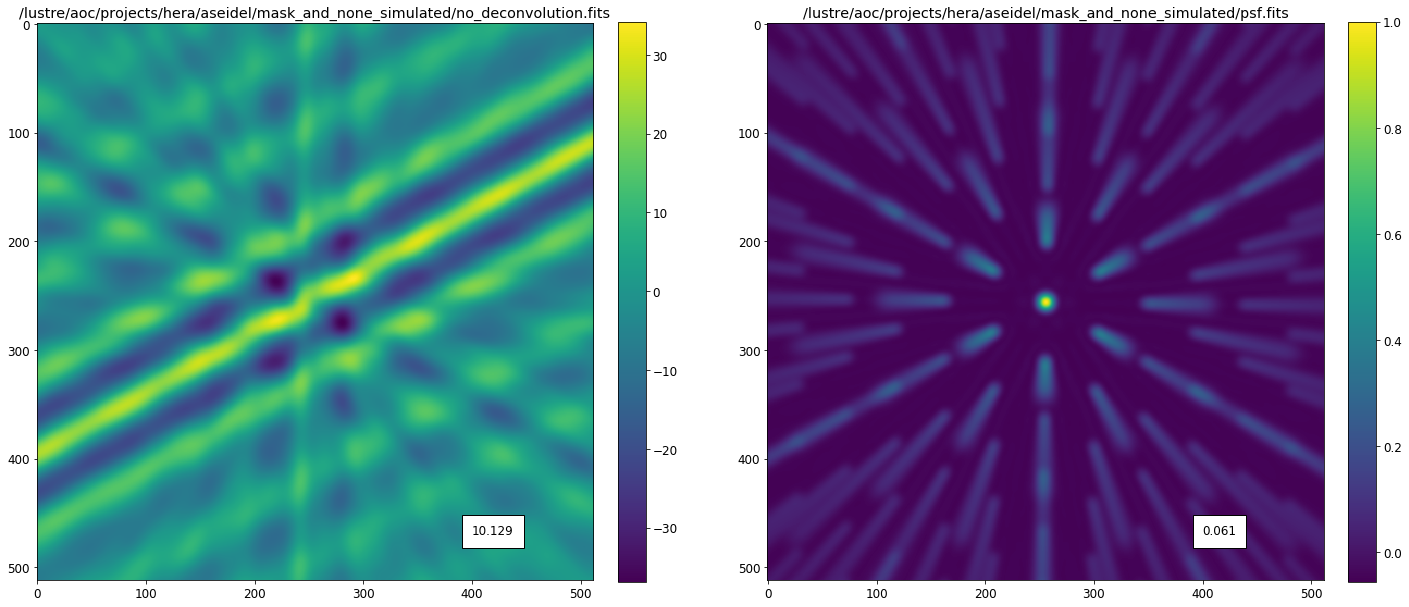

In [55]:
path = "/lustre/aoc/projects/hera/aseidel/mask_and_none_simulated/"
no_deconvolution = glob.glob(path+"no_deconvolution.fits")
psf = glob.glob(path+"psf.fits")
plot_all(fits_names=no_deconvolution + psf)

In [56]:
pstring = lambda s : s.split('_')[-5] + s.split('_')[-2] + s

residual = sorted(glob.glob(path + "*final.residual.fits"), key=pstring)
model = sorted(glob.glob(path + "*final.model.fits"), key=pstring)
image = sorted(glob.glob(path + "*final.image.fits"), key=pstring)
titles = [x.split('/')[-1][:-20] for x in residual]

In [57]:
muellerbeam = get_stokes_i("muellerbeam.fits")[0]

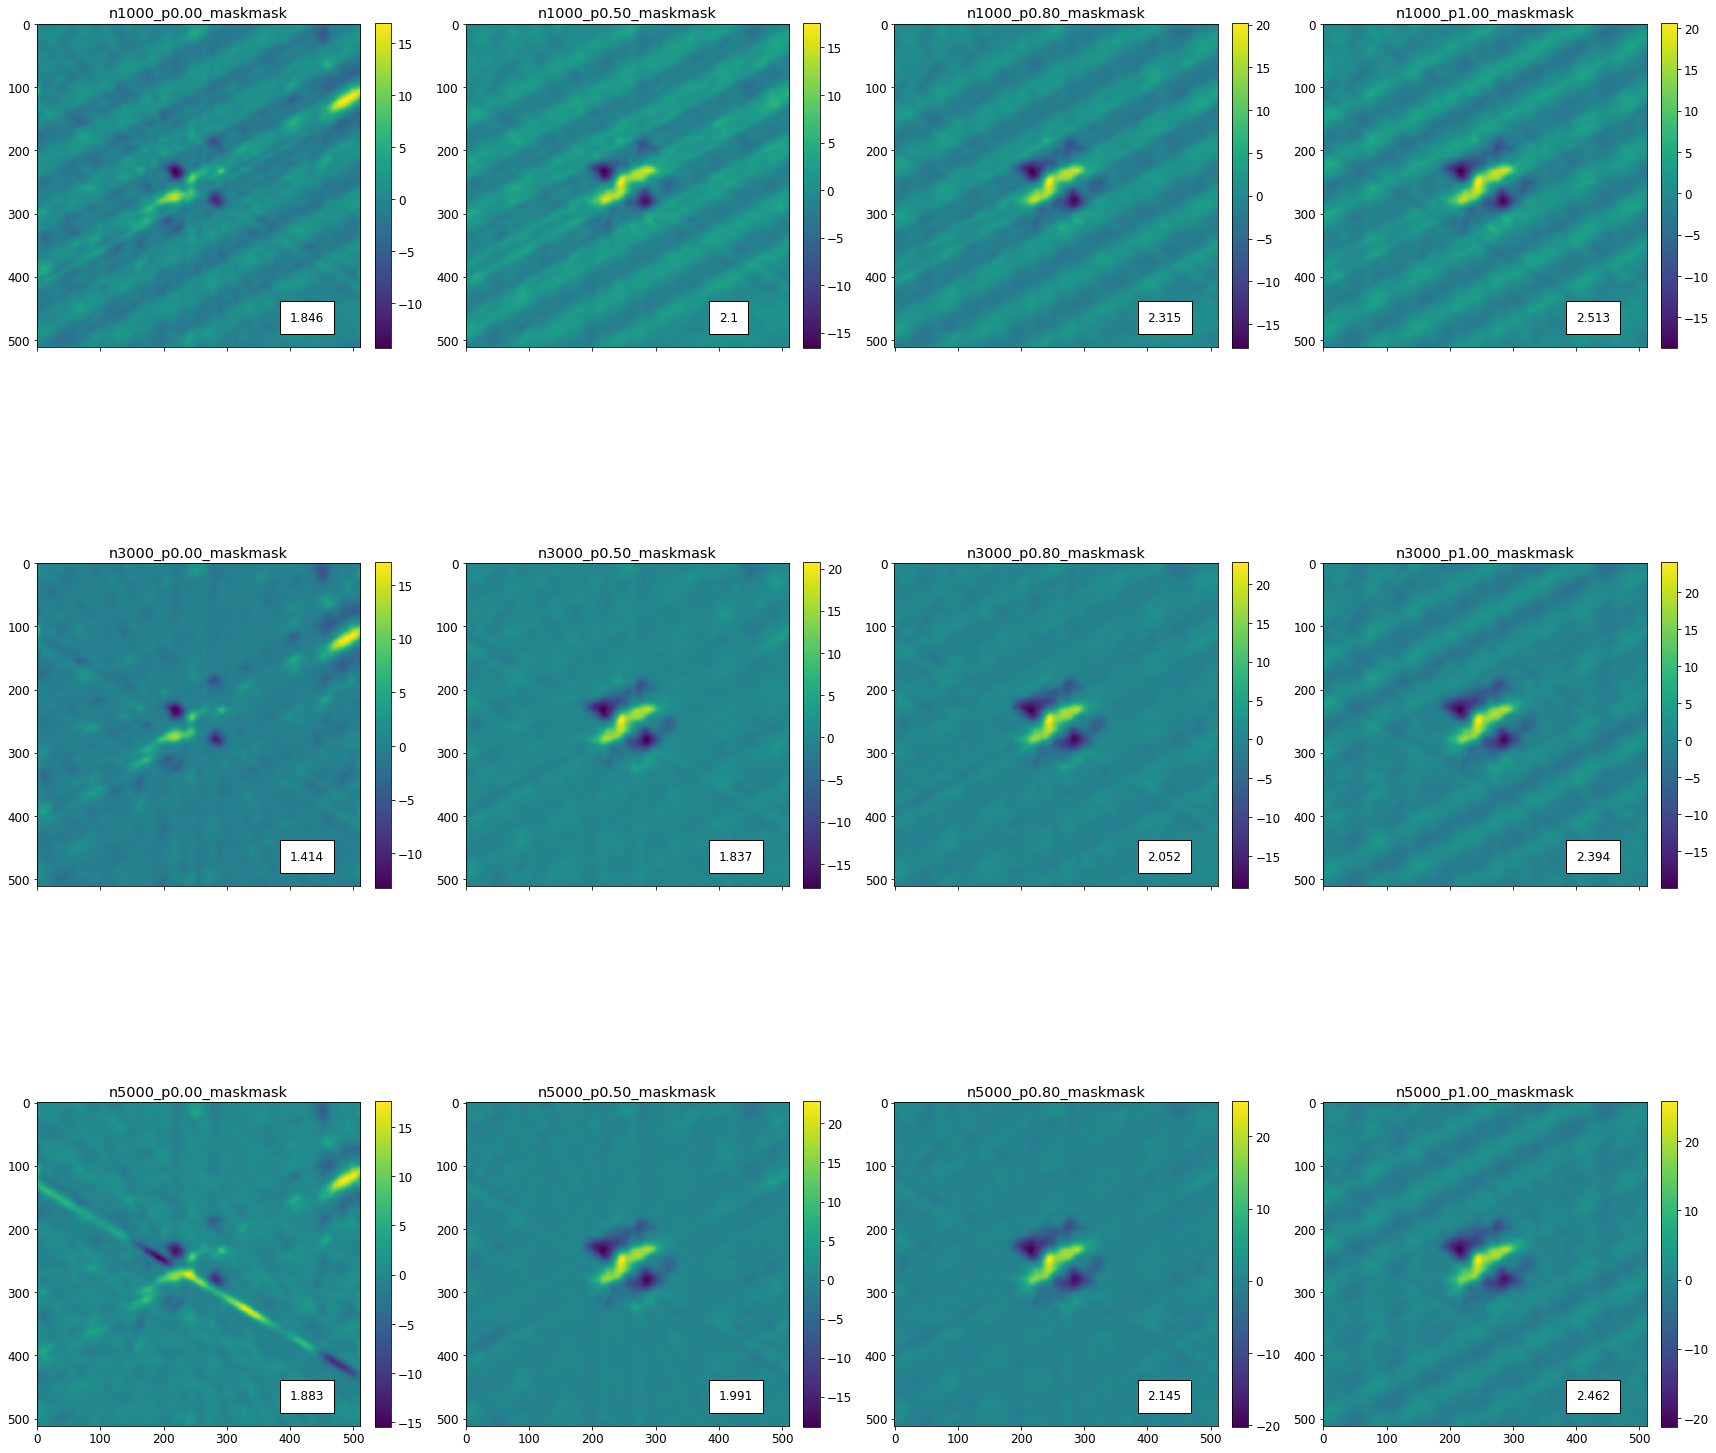

In [58]:
def weighted_std(data):
    weight = muellerbeam > 0.2 * muellerbeam
    weighted_mean = np.average(data, weights=weight)
    return (np.sum((weight * (data - weighted_mean)**2)) / np.sum(weight))**0.5

plot_all(fits_names=[image], rows=3, titles=titles, display_statistic=weighted_std)
plt.tight_layout()

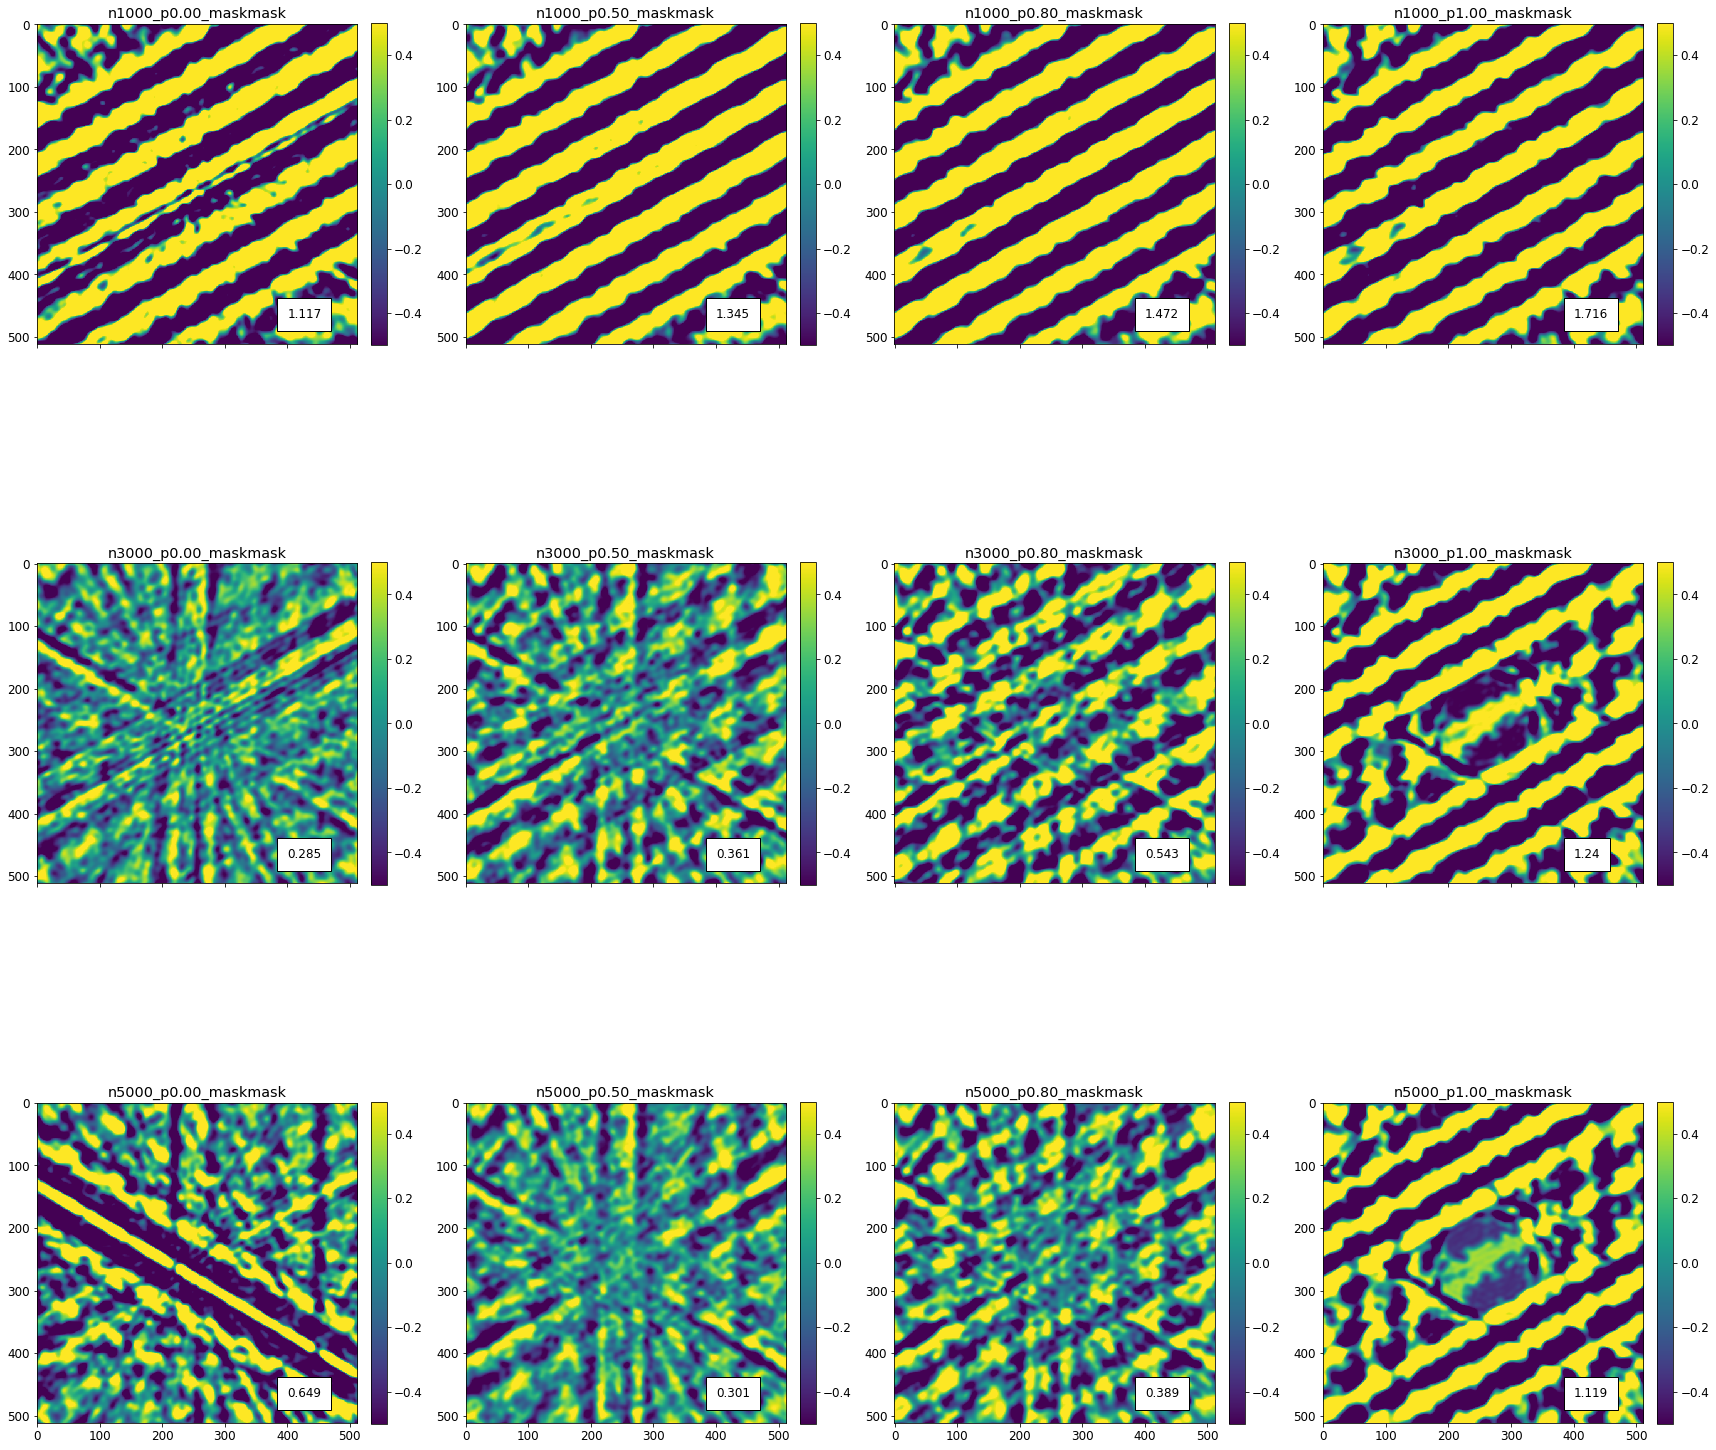

In [59]:
plot_all(fits_names=[residual], rows=3, titles=titles, lim=[-0.5,0.5], display_statistic=weighted_std        )
plt.tight_layout()

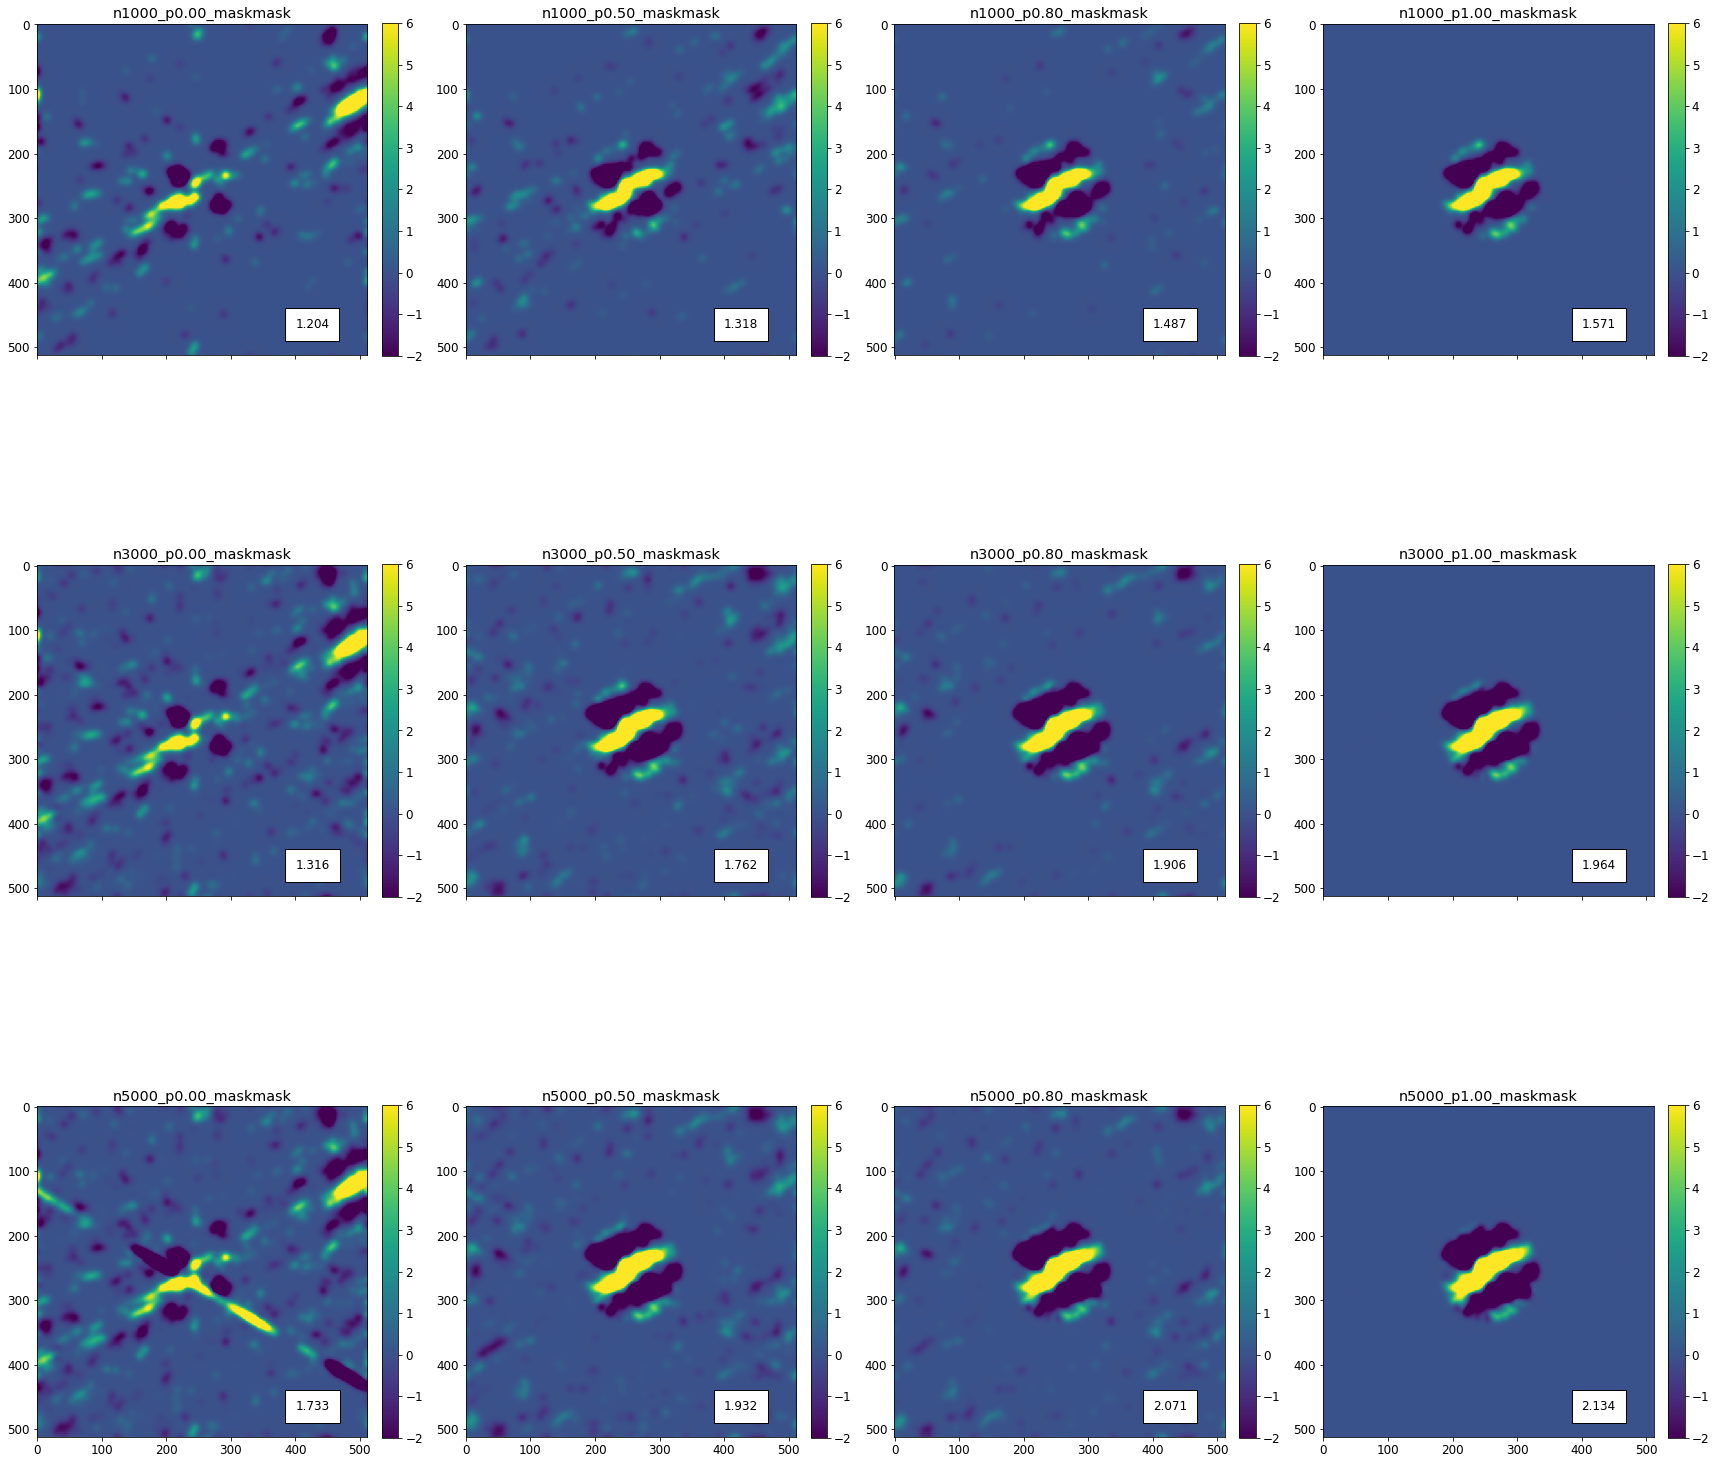

In [60]:
plot_all(fits_names=[image, residual], rows=3, titles=titles, lim=[-2,6], display_statistic=weighted_std,
         combine = lambda d : d[0] - d[1])
plt.tight_layout()

/lustre/aoc/projects/hera/aseidel/anaconda3/envs/hera/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


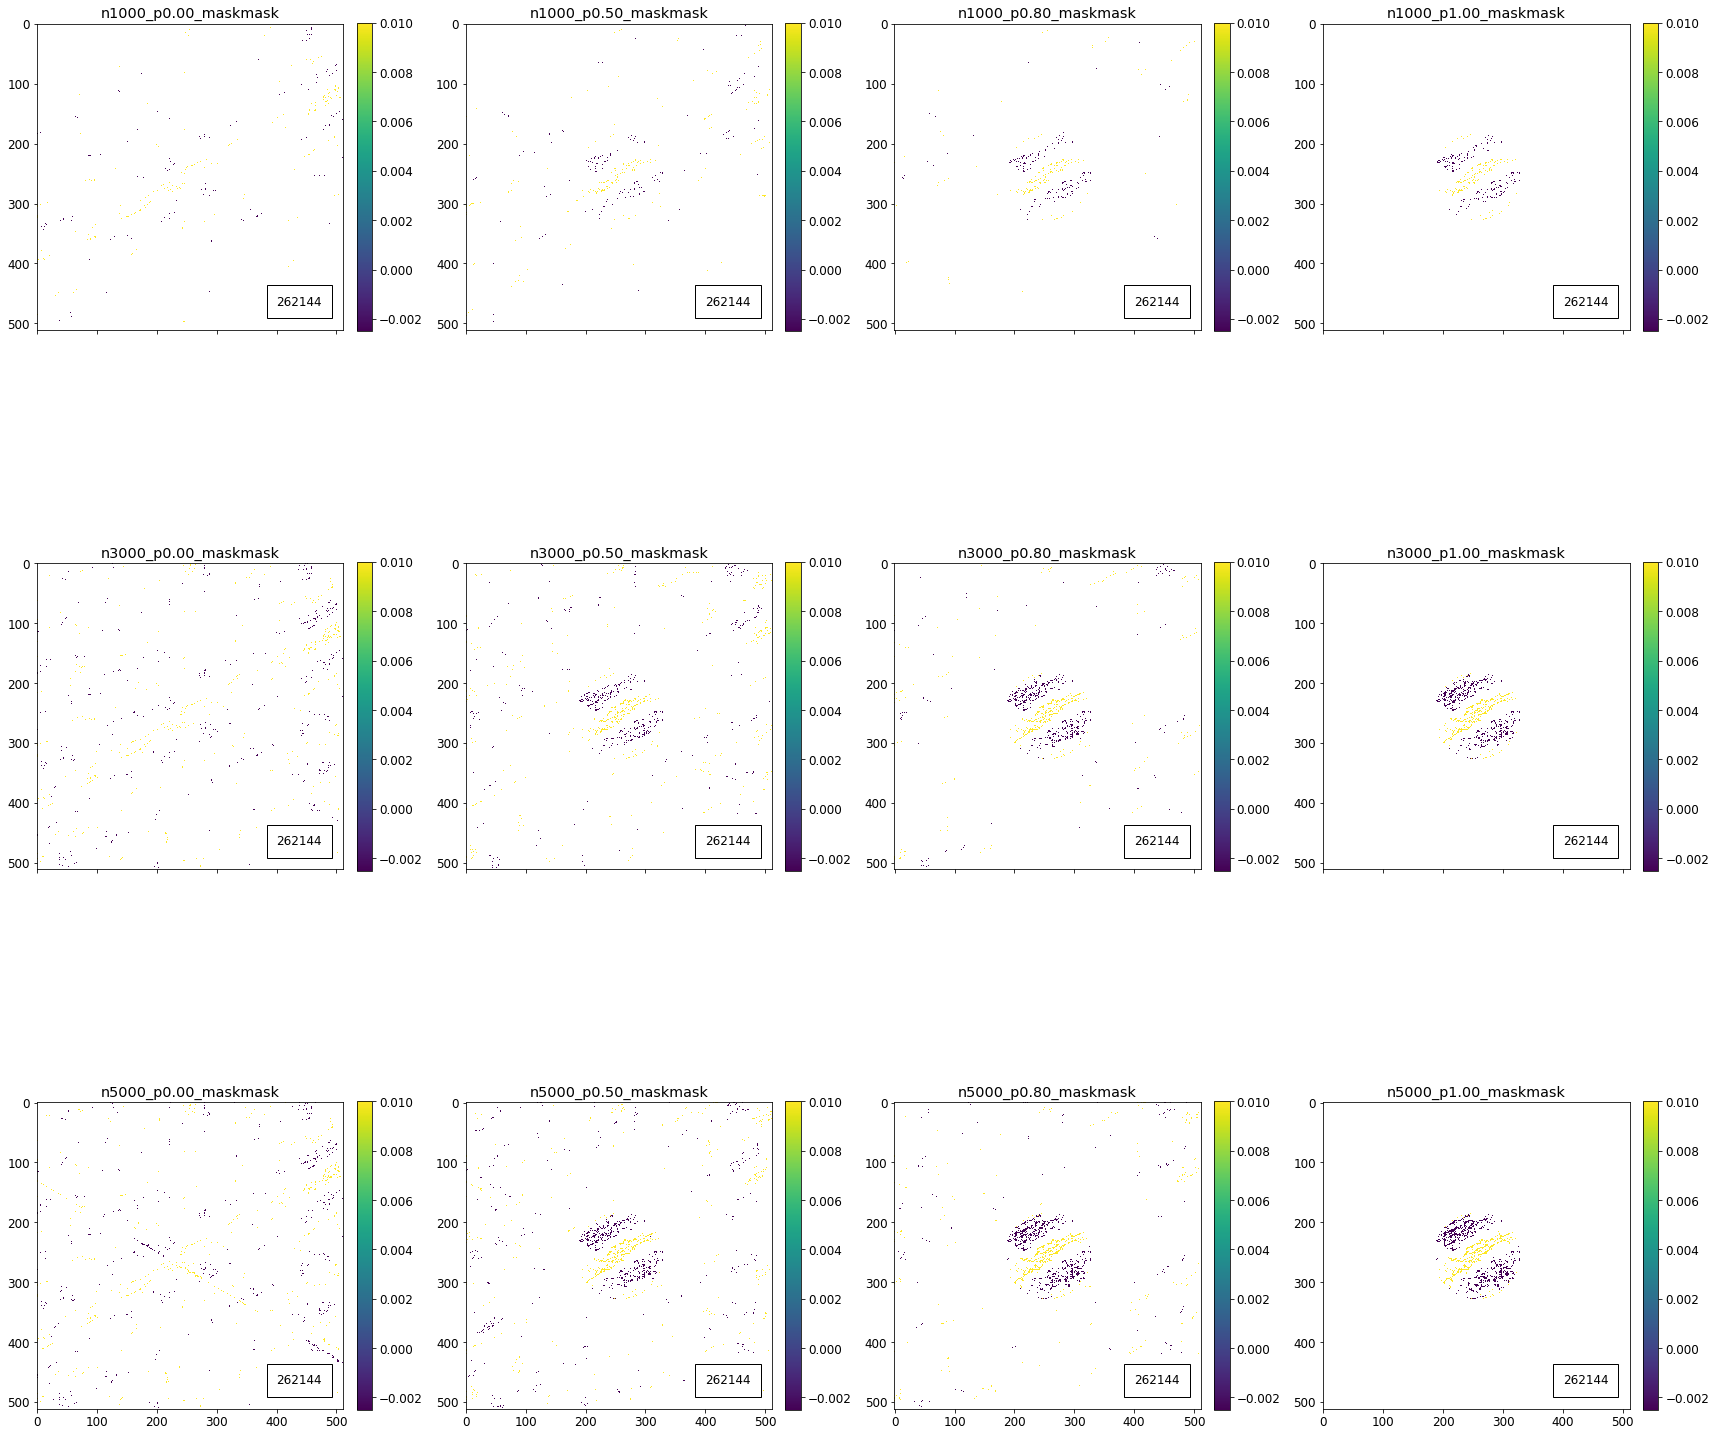

In [61]:
plot_all(fits_names=[model], rows=3, titles=titles, 
         combine = lambda d : d[0] / (d[0] != 0), lim=[-0.0025,0.01],
         display_statistic = lambda d : np.sum(d != 0))
plt.tight_layout()

(<Figure size 1728x1728 with 4 Axes>,
 [array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f99facb4510>,
        dtype=object)])

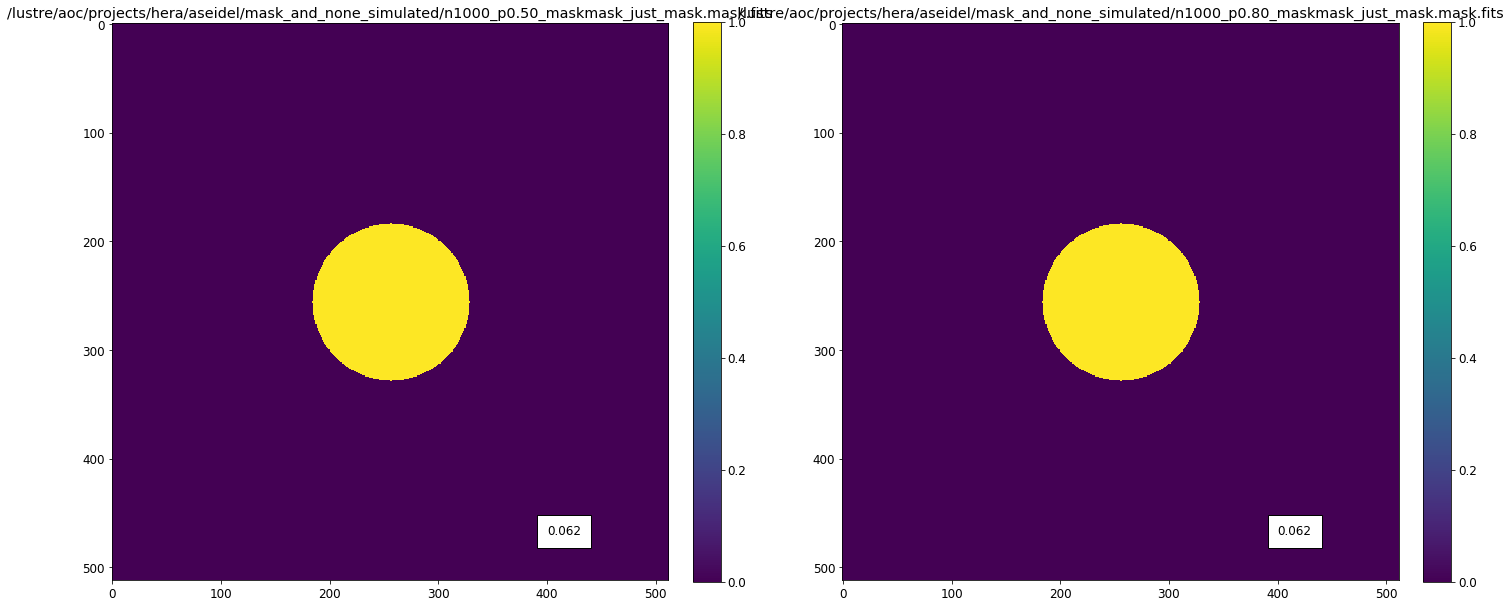

In [62]:
plot_all(sorted(glob.glob(path+"*mask.fits"))[0:2], rows=1, display_statistic=np.mean)

/lustre/aoc/projects/hera/aseidel/anaconda3/envs/hera/lib/python3.7/site-packages/pixell/enmap.py:2273: UserWarning: FITS file has stokes axis, but no POLCCONV is specified. Assuming IAU
  warnings.warn("FITS file has stokes axis, but no POLCCONV is specified. Assuming IAU")
/lustre/aoc/projects/hera/aseidel/anaconda3/envs/hera/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
(4, 1, 512, 512)


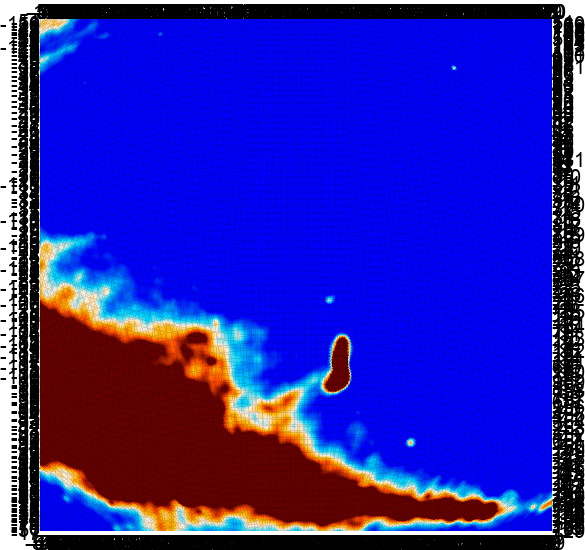

'Done!'

In [51]:
#from Gonzalo's GSM_modeling

import healpy as hp
from pixell import enmap
from pixell import reproject
from pixell import enplot
from astropy.wcs import WCS

# Convenient wrapper for displaying enmaps
def eshow(x,**kwargs): enplot.show(enplot.plot(x,**kwargs)) 

def GSM_from_fits(fitsfile,outfile,showplot=True):
    """This function will take a fitsfile, and create a GSM model of same area
    Arguments: 
    fitsfile: Path to fits file with shape (nx,ny,pol,freq
    outfile: Name of output GSM fits file
    Returns:
    GSM model over area of input fitsimage
    """
    #read in input fits image
    image = enmap.read_map(fitsfile)
    #read GSM model
    gsm_hp = hp.read_map('/lustre/aoc/projects/hera/gtucker/repositories/plimpy/PolarizedImaging/GSM150MHz.fits')
    #Project a healpix map to an enmap of chosen shape and wcs
    print(image.shape)
    gsm = reproject.enmap_from_healpix_interp(gsm_hp, image[0,0,:,:].shape, image.wcs)
    gsm -= gsm.mean()
    #print(gsm)
    if showplot == True:
        eshow(gsm, min=-45, max = 300)
    else:
        pass
    enmap.write_fits(outfile+'.fits',gsm)
    return 'Done!'
#A test
GSM_from_fits(no_deconvolution[0], path+'GSM_test')

(<Figure size 1728x1728 with 2 Axes>,
 [[<matplotlib.axes._subplots.AxesSubplot at 0x7f99fabf1a50>]])

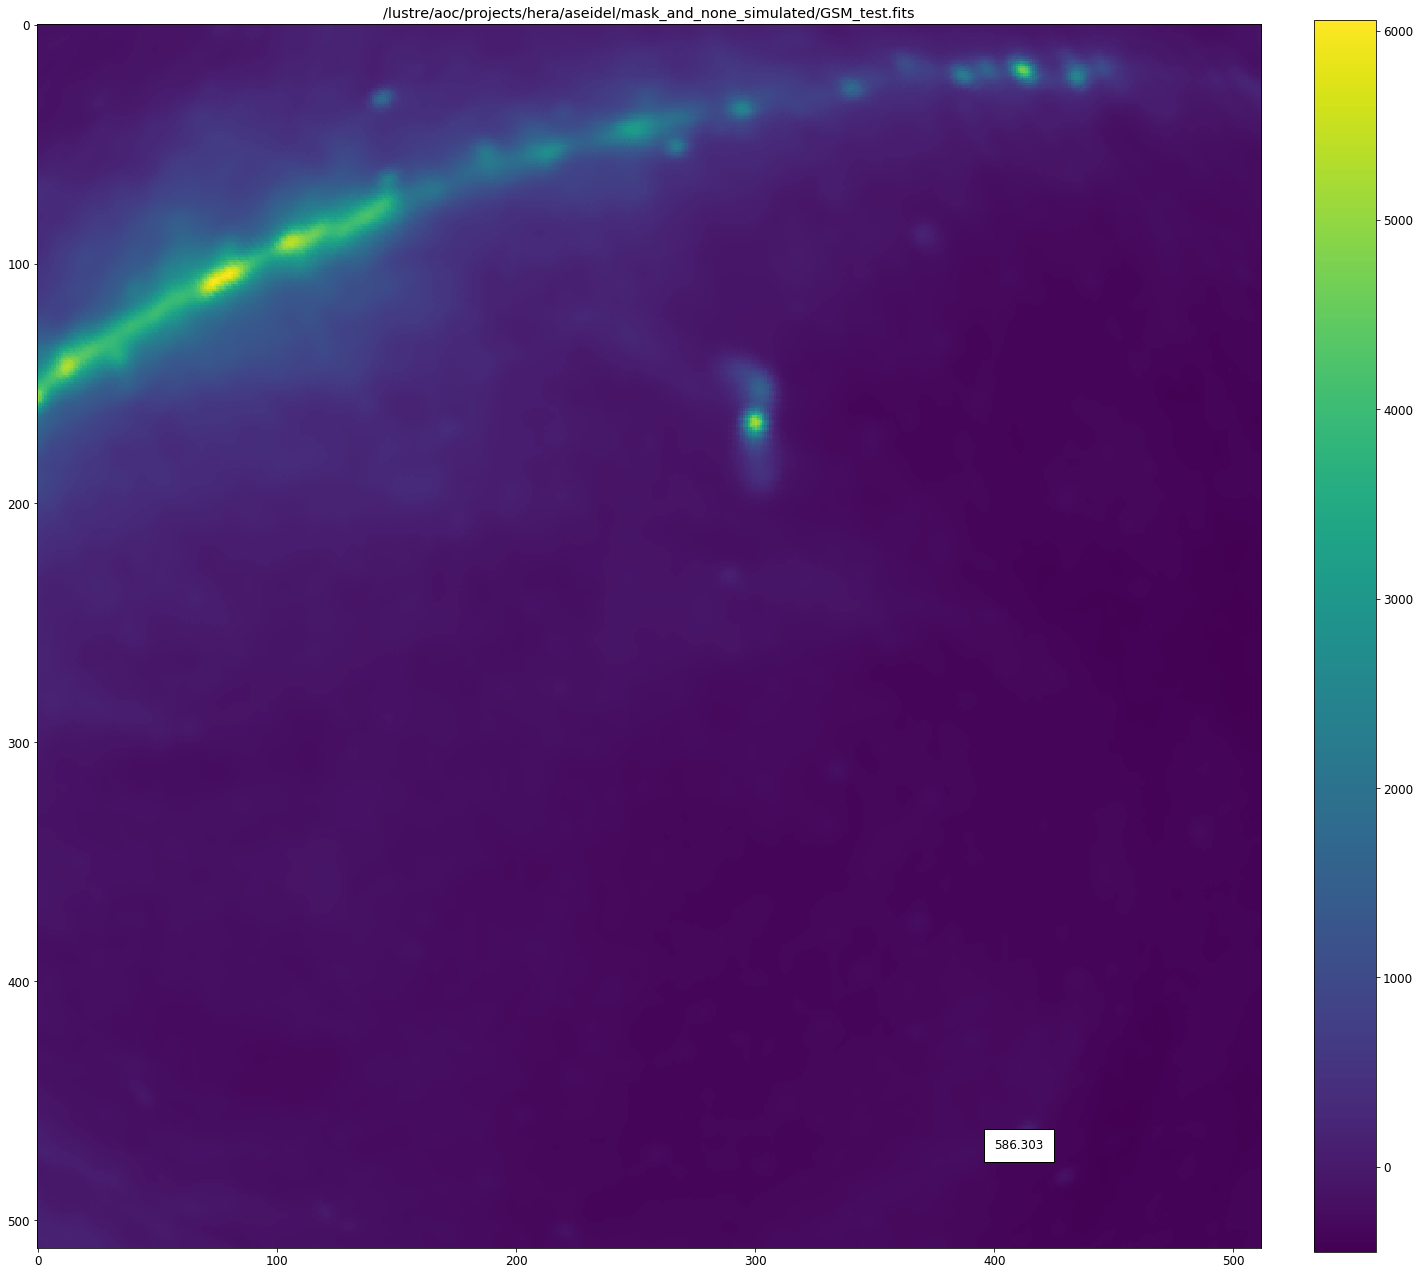

In [46]:
plot_all(path+'GSM_test.fits')

In [ ]:
plot_all(sorted(glob.glob("*mask.fits"))[0:2] + sorted(glob.glob("new_mask_*Jy.fits")), 
         titles=["0.5Jy circle cutoff mask", "1.0Jy circle cutoff mask", "0.5Jy pb brightness mask", "1.0Jy pb brightness mask"],
        rows=1, display_mean=True)
plt.tight_layout()
plt.savefig('new_and_old_masks.png')

In [ ]:
plot_all(['../../mask_and_none_new_mask/new_0.25Jymask.fits'])